In [2]:
import os
os.environ['CMDSTAN'] = '/Users/michelafrigeri/.cmdstan/cmdstan-2.28.2'
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [22]:
# Dataset import

df = pd.read_csv("Py_Dataset.csv")
df.head()

,Unnamed: 0,Date,Y_log,Rural,Time,NS,quota,Provincia,Zonizzazione,Tipo
0,1,2018-01-01,3.688645,1,0,BADIA,0.522332,PR,Pianura Ovest,Fondo
1,2,2018-01-02,2.743930,1,1,BADIA,0.522332,PR,Pianura Ovest,Fondo
2,3,2018-01-03,2.687557,1,2,BADIA,0.522332,PR,Pianura Ovest,Fondo
3,4,2018-01-04,2.850192,1,3,BADIA,0.522332,PR,Pianura Ovest,Fondo
4,5,2018-01-05,3.558992,1,4,BADIA,0.522332,PR,Pianura Ovest,Fondo


2.305659897197481

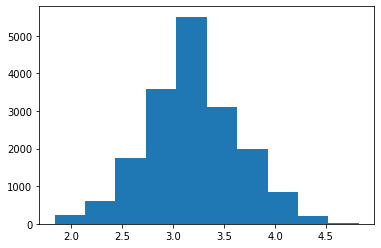

In [3]:
plt.hist(df.Y_log)
np.std(df.Y_log)*5 # a = 2, b = 3 per invgamma

In [23]:
# dummies

dummies = pd.get_dummies(df.Tipo)
dummies.head()

,Fondo,Industriale,Traffico
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


# MODEL INPUT

- N = length(Y) = number of total samples 
- k = number of Fourier basis (2/4/8/12)
- p = 3 = number of regressors {quota + tipo(dummyx2)}


- y {N vector} : PM10 time series
- x {Nxp matrix} : covariates matrix
- t {N vector} : time istant
- r {N vector binary} : 1 if rural, 0 otherwise
- omega = 2$\pi$/365 : annual frequency


# MODEL PARAMETERS

- a {k/2 vector} : sin coefficients
- b {k/2 vector} : cos coefficients
- c {real} : constant term for f(t)


- a_r {k/2 vector} : sin coefficients - rural 
- b_r {k/2 vector} : cos coefficients - rural
- c_r {real} : constant term for fr(t) - rural


- beta {p vector} : covariates coefficients
- sigma_sq {real > 0} : y variance


In [15]:
normal_reg = """
data {
    int<lower=0> N; 
    int<lower=0> k;
    int<lower=0> p;
    int<lower=0> G;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    int stazione[N];
    real omega;
    row_vector[2] coord[G];
}

transformed data {
    int K;
    K = k%/%2;
}

parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[K] a;
    vector[K] b;
    real c;
    
    vector[K] a_r;
    vector[K] b_r;
    real c_r;
    
    vector[G] w;
    real rho;
    real alpha;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(c, N));
    for (j in 1:K){
     ft += a[j]*sin(j*omega*t) + b[j]*cos(j*omega*t);
    }
    
    vector[N] ft_r;
    ft_r = to_vector(rep_array(c_r, N));
    for (j in 1:K){
     ft_r += a_r[j]*sin(j*omega*t) + b_r[j]*cos(j*omega*t);
     }
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) 
         + X*beta ;
    mu[1:N] += w[stazione[1:N]];
         
    cov_matrix[G] H = cov_exp_quad(coord, alpha, rho);
    cov_matrix[G] L = cholesky_decompose(H);
}

model {  

    sigma_sq ~ inv_gamma(2, 3);
    
    beta ~ normal(0, 10);
    
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    a_r ~ normal(0, 10);
    b_r ~ normal(0, 10);
    c_r ~ normal(0, 10);
    
    w ~ multi_normal_cholesky(rep_vector(0,G),L);
    
    
    Y ~ normal(mu, sigma);  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
}
"""

stan_file = "./normal_reg.stan"

with open(stan_file, "w") as f:
    print(normal_reg, file=f)

normal_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_reg
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
Warning in '/Users/michelafrigeri/JupyterProjects/PROGETTO/normal_reg.stan', line 63, column 22: cov_exp_quad is deprecated and will be removed in the future. Use gp_exp_quad_cov instead.
INFO:cmdstanpy:compiled model file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_reg


In [24]:
y = np.array(df.Y_log)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
omega = 2*np.pi/365

N = len(y)
p = 3   # Quota + Tipo(2 dummies)
k = 2   # 4 basi di fourier + const

In [39]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "k": k,   # Fbasis number
    "p": p,   # 3
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,   
    "omega": omega
}

fit = normal_reg.sample(data=reg_data, chains=3, parallel_chains=3, 
                             iter_warmup=700, iter_sampling=2300, show_progress=True)


Chain 2 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 1 - warmup:   0%|                                | 0/3000 [00:00<?, ?it/s]

Chain 1 - warmup:   3%|▋                     | 100/3000 [00:15<07:29,  6.45it/s]

Chain 1 - warmup:   7%|█▍                    | 200/3000 [00:33<08:01,  5.81it/s]

Chain 2 - warmup:  10%|██▏                   | 300/3000 [00:54<08:04,  5.57it/s]

Chain 2 - warmup:  13%|██▉                   | 400/3000 [01:09<07:18,  5.94it/s]

Chain 1 - warmup:  17%|███▋                  | 500/3000 [01:22<06:41,  6.23it/s]

Chain 2 - warmup:  20%|████▍                 | 600/3000 [01:39<06:17,  6.35it/s]

Chain 2 - sample:  23%|█████▏                | 701/3000 [01:55<06:00,  6.38it/s]

Chain 3 - warmup:  23%|█████▏                | 700/3000 [01:55<06:05,  6.29it/s]

Chain 3 - sample:  23%|█████▏                | 700/3000 [01:55<06:05,  6.29it/s]

Chain 1 - sample

In [40]:
normal_az = az.from_cmdstanpy(fit)

In [37]:
type(fit)

cmdstanpy.stanfit.CmdStanMCMC

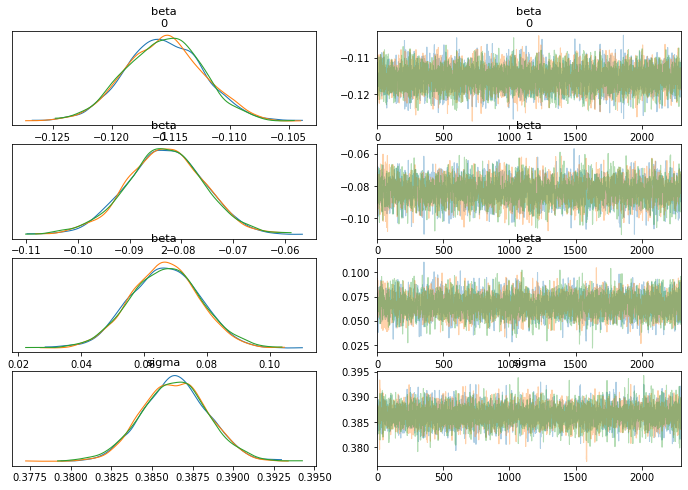

In [41]:
# parameters: beta and sigma
az.plot_trace(normal_az, var_names=["beta", "sigma"], compact=False)
plt.show()

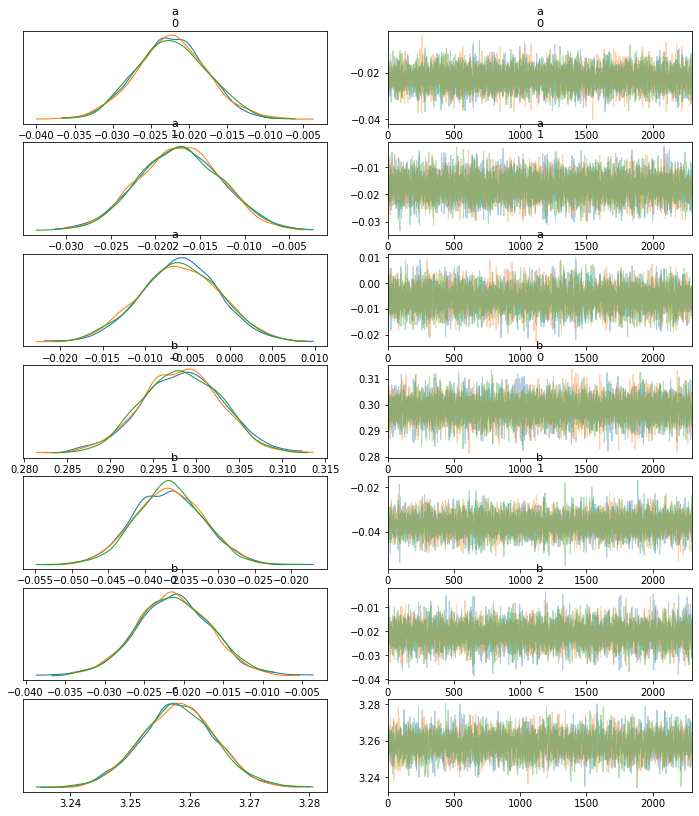

In [42]:
# parameters NON-rural f(t)
az.plot_trace(normal_az, var_names=["a", "b", "c"], compact=False)
plt.show()

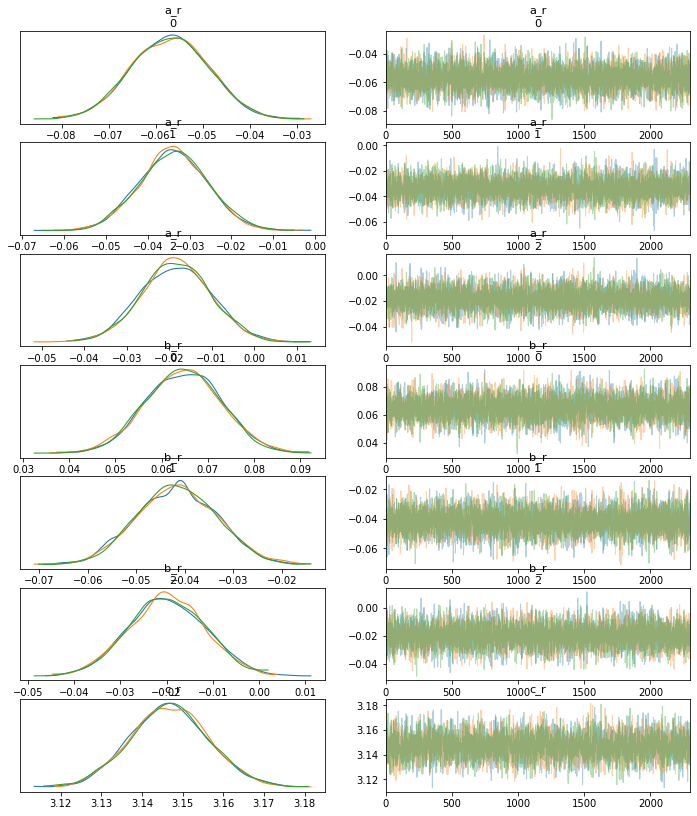

In [43]:
# parameters rural f(t)
az.plot_trace(normal_az, var_names=["a_r", "b_r", "c_r"], compact=False)
plt.show()

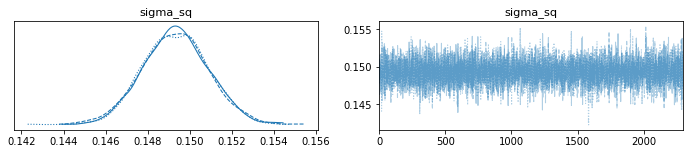

In [44]:
# transformed parameters: sigma^2
az.plot_trace(normal_az, var_names=["sigma_sq"])
plt.show()

In [46]:
# iterazioni divergenti? Nessuna
np.sum(normal_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [45]:
# GOF analysis
print("WAIC: ", az.waic(normal_az, var_name="log_lik"))

WAIC:  Computed from 6900 by 17836 log-likelihood matrix

          Estimate       SE
elpd_waic -8339.69   108.03
p_waic       19.08        -


In [14]:
print("LOO: ", az.loo(normal_az, var_name="log_lik"))

LOO:  Computed from 16000 by 17836 log-likelihood matrix

         Estimate       SE
elpd_loo -8462.26   106.79
p_loo       11.58        -


In [28]:
normal_2 = """
data {
    int<lower=0> N; 
    int<lower=0> p;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    real omega;
}


parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[4] a;
    vector[4] b;
    real c;
    
    vector[4] a_r;
    vector[4] b_r;
    real c_r;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(c, N));
    ft = a[1]*sin(omega*t) + b[1]*cos(omega*t) 
         + a[2]*sin(6*omega*t) + b[2]*cos(6*omega*t)
         + a[3]*sin(12*omega*t) + b[3]*cos(12*omega*t)
         + a[4]*sin(52*omega*t) + b[4]*cos(52*omega*t);
    
    
    vector[N] ft_r;
    ft_r = to_vector(rep_array(c_r, N));
    ft_r += a_r[1]*sin(omega*t) + b_r[1]*cos(omega*t) 
            + a_r[2]*sin(6*omega*t) + b_r[2]*cos(6*omega*t) 
            + a_r[3]*sin(12*omega*t) + b_r[3]*cos(12*omega*t)
            + a_r[4]*sin(52*omega*t) + b_r[4]*cos(52*omega*t);
    
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) 
         + X*beta;
}

model {  

    sigma_sq ~ inv_gamma(2, 3);
    
    beta ~ normal(0, 10);
    
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    a_r ~ normal(0, 10);
    b_r ~ normal(0, 10);
    c_r ~ normal(0, 10);
    
    
    Y ~ normal(mu, sigma);  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
}
"""

stan_file = "./normal_2.stan"

with open(stan_file, "w") as f:
    print(normal_2, file=f)

normal_2 = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_2
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_2


In [30]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "p": p,   # 3
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,   
    "omega": omega
}

fit = normal_2.sample(data=reg_data, chains=3, parallel_chains=3, 
                             iter_warmup=700, iter_sampling=2300, show_progress=True)

Chain 2 -   done: 100%|█████████████████████| 2500/2500 [05:39<00:00,  7.37it/s]


In [31]:
normal_az_2 = az.from_cmdstanpy(fit)

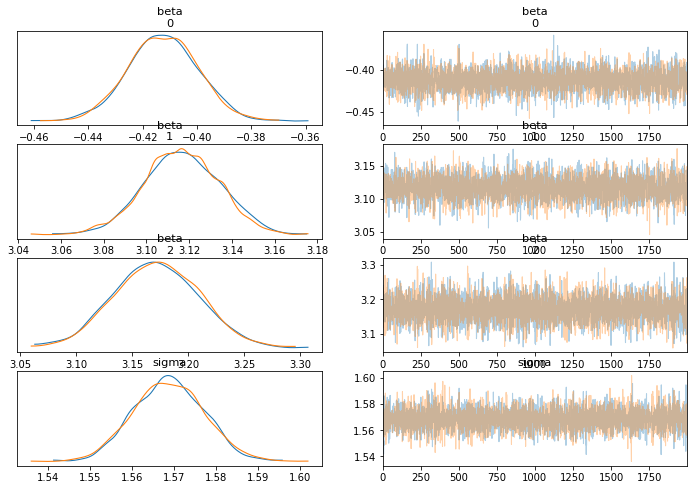

In [32]:
# parameters: beta and sigma
az.plot_trace(normal_az_2, var_names=["beta", "sigma"], compact=False)
plt.show()

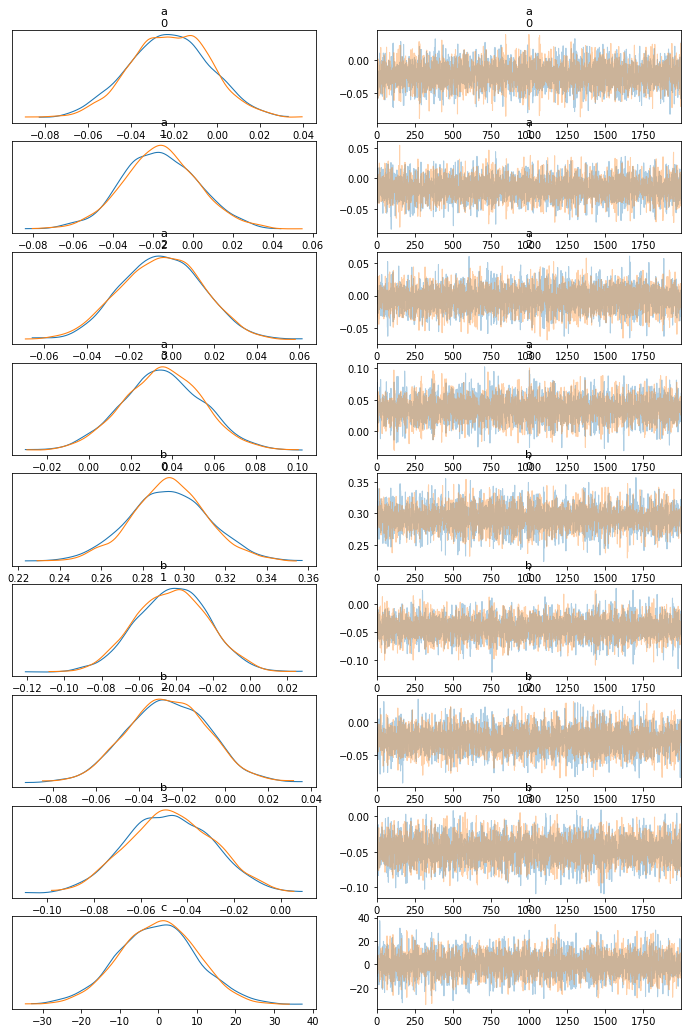

In [33]:
# parameters NON-rural f(t)
az.plot_trace(normal_az_2, var_names=["a", "b", "c"], compact=False)
plt.show()

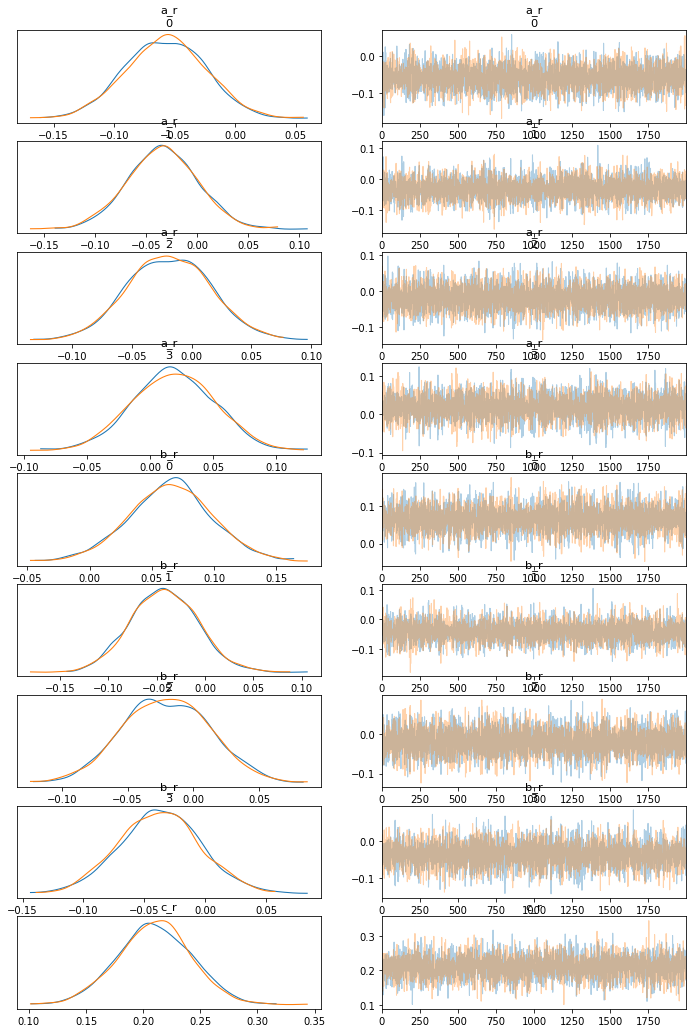

In [34]:
# parameters rural f(t)
az.plot_trace(normal_az_2, var_names=["a_r", "b_r", "c_r"], compact=False)
plt.show()

In [ ]:
# per scegliere modello migliore
# az.compare({"model_1": normal_az, "model_2": modello_new})